In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from subprocess import Popen, PIPE

# Path to the PULSE executable
PULSE_PATH = "../../pulse.exe"

# Pulse loads local resources, so we need to set the working directory to the location of the executable
PULSE_CWD = os.path.dirname( os.path.realpath(PULSE_PATH) )

# Path to the data folder relative to PULSE_CWD
DATA_PATH = "examples/example_1/data/"

# Create results and load folders
result_path = os.path.join(PULSE_CWD, DATA_PATH, "results")
load_path = os.path.join(PULSE_CWD, DATA_PATH, "load")

# Create Target Directories
os.makedirs(result_path, exist_ok=True)
os.makedirs(load_path, exist_ok=True)

# System Parameters
grid_size = 200                 # Grid Size, int this case 200x200
x_max = 10                      # mum; Maximum Distance in one direction, meaning the grid will be from -10mum to 10mum
effective_mass = 0.5*5.864E-4   # kg; Effective Mass of the electron, scaled
gamma_c = 0.16                  # Polariton Loss Rate
gamma_r = 1.5 * gamma_c         # Reservoir Loss Rate
R = 0.01                        # Condensation Rate
g_c = 6E-6                      # Polariton-Polariton Coupling
g_r = 2*g_c                     # Polariton-Reservoir Coupling
t_end = 1500                    # ps; End time of the simulation

# Additional Parameters not required by PULSE:
hbar = 6.582119569E-4
dx = 2*x_max/grid_size

# Matrix Generation

While PULSE can also generate spacial shapes via its envelope syntax, it is usually beneficial to pre-generate all required inputs. This way, we can plot and verify the inputs beforehand.

We generate an X-Y Meshgrid using numpy, fill the pump and potential matrices and plot them. Because we want to vary the first pump amplitude, we create a lambda for the pump creation.

We also plot the inputs for verification purposes. We can save the matrices using one `X Y Re Im` pair per line. Note, that PULSE reads the matrices as row major inputs, ignoring the X and Y components. 


In [97]:
# X-Y Meshgrid
x = np.linspace(-x_max, x_max, grid_size, endpoint=False)
y = np.linspace(-x_max, x_max, grid_size, endpoint=False)
X, Y = np.meshgrid(x, y)

# Helper Function to save the numpy matrices into a format PULSE can read
def save_matrix(matrix, filename):
    header = f"SIZE {grid_size} {grid_size} {x_max} {x_max} {dx} {dx} PYTHON-GENERATED"
    # if real matrix
    if np.isrealobj(matrix):
        np.savetxt( os.path.join(load_path, filename), matrix, header=header )
    else:
        np.savetxt( os.path.join(load_path, filename), matrix.real, header=header )

## Pump Generation ##

# Spacing shifts both the pump and the potential wells
spacing = 4.0

# Pump 
pump1_amp = 4.0
pump1_w = 1.0
pump2_amp = 12.0
pump2_w = 1.0

# We create a lambda for the pump because we are going to vary the pump amplitude in the optimization and scanning process
generate_pump = lambda pump_varied: pump_varied*np.exp(-np.sqrt((X+spacing/2)**2 + Y**2) / (pump1_w**2) ) + pump2_amp*np.exp(-np.sqrt( (X-spacing/2)**2 + Y**2 ) / (pump2_w**2) )
pump = generate_pump(pump1_amp)

# Save the pump using X,Y,Re,Im format
save_matrix(pump, "pump_plus.txt")

## Potential Generation ##

potential1_amp = -2E-3
potential1_w = 1.5
potential2_amp = -2.2E-3
potential2_w = 1.5
potential_order = 2

potential = potential1_amp*np.exp(-( ((X+spacing/2)**2 + Y**2)/(potential1_w**2) )**potential_order ) + potential2_amp*np.exp(-( ((X-spacing/2)**2 + Y**2)/(potential2_w**2) )**potential_order)

# Save the potential using X,Y,Re,Im format
save_matrix(potential, "potential_plus.txt")

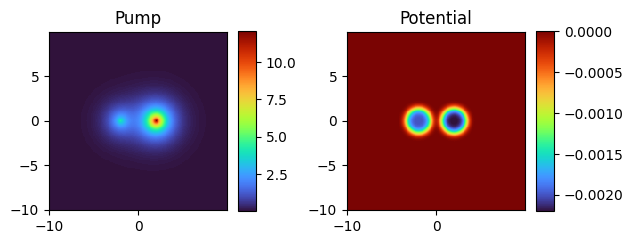

In [98]:
# Plot the pump and potential
fig, (ax1,ax2) = plt.subplots(1,2)
plt_pump = ax1.pcolormesh(X,Y,pump, cmap="turbo")
ax1.set_title("Pump")
plt_pot = ax2.pcolormesh(X,Y,potential, cmap="turbo")
ax2.set_title("Potential")

# Colorbars
fig.colorbar(plt_pump, shrink=0.4, aspect=10)
fig.colorbar(plt_pot, shrink=0.4, aspect=10)
[ax.set_aspect("equal") for ax in (ax1,ax2)]

plt.tight_layout()

# Execute Pulse

We create a function to generate the PULSE compatible commandline runstring and execute a test calculation.

We also plot the test calculation. The density for the given set of parameters should approach zero.


In [68]:
# Runstring generator
def generate_runstring( *, t_max: float, history: bool = False ):
    # Generate Load Path relative to PULSE_CWD
    relative_result_path = os.path.relpath(result_path, PULSE_CWD).replace("\\", "/")
    relative_load_path = os.path.relpath(load_path, PULSE_CWD).replace("\\", "/")
    runstring = f"{PULSE_PATH} "
    runstring += f"--path {relative_result_path} "      # Set the output path
    runstring += f"--loadFrom {relative_load_path} "    # Set the load path
    runstring += "--input all "                         # Set the input to all
    runstring += f"--N {grid_size} {grid_size} "        # Set the grid size in points
    runstring += f"--L {x_max} {x_max} "                # Set the grid size in mum
    runstring += f"--meff {effective_mass} "            # Set the effective mass
    runstring += f"--tmax {t_max} "                     # Set the end time
    runstring += "--outEvery 0.5 "                      # Set sample rate to 0.5ps
    runstring += f"--gc {g_c} "                         # Set the coupling constants
    runstring += f"--gr {g_r} "                         # Set the coupling constants
    runstring += f"--R {R} "                            # Set the condensation rate
    runstring += f"--gammaR {gamma_r} "                 # Set the reservoir loss rate
    runstring += f"--gammaC {gamma_c} "                 # Set the polariton loss rate
    runstring += "-nosfml "                             # Disable SFML output
    runstring += "--fftMask 1.0 add 0.3 0.3 0 0 both 10 none gauss+local+noDivide " # Set the FFT mask
    runstring += "--fftEvery 0.1 "                      # Set the FFT sample rate
    runstring += "--initRandom 1E-7 random "            # Randomly initialize the wavefunction if we cannot load the wavefunction
    runstring += "--boundary periodic periodic "        # Set periodic boundary conditions in both directions
    if history:
        runstring += "--historyMatrix 50 150 50 150 1 " # Add Time Matrix History output
        runstring += "--output wavefunction"            # Output only the wavefunction
    return runstring

In [95]:
# Test Calculation, Execute PULSE
runstring = generate_runstring( t_max = 50 )
# Call the runstring and wait for the subprocess to finish
process = Popen( runstring.split(), stdout=PIPE, stderr=PIPE, cwd = PULSE_CWD )
stdout, stderr = process.communicate()
# Print the output
print(stdout.decode("utf-8"))

---------------------------- Inputting System Parameters --------------------------
Successfully created directory examples/example_1/data/results/
Creating Solver with TE/TM Splitting: 0
--------------------------- Initializing Host Matrices ----------------------------
Initializing Host Matrices...
Initializing Pump Envelopes...
Initializing Potential Envelopes...
Initializing FFT Envelopes...
Initializing Soll Mask Envelopes...
-------------------------------- Loading Matrices ---------------------------------
Load Path: examples/example_1/data/load
Loading 40000 elements from examples/example_1/data/load/pump_plus.txt
Row 1 Col 200
Row 2 Col 200
Row 3 Col 200
Row 4 Col 200
Row 5 Col 200
Row 6 Col 200
Row 7 Col 200
Row 8 Col 200
Row 9 Col 200
Row 10 Col 200
Row 11 Col 200
Row 12 Col 200
Row 13 Col 200
Row 14 Col 200
Row 15 Col 200
Row 16 Col 200
Row 17 Col 200
Row 18 Col 200
Row 19 Col 200
Row 20 Col 200
Row 21 Col 200
Row 22 Col 200
Row 23 Col 200
Row 24 Col 200
Row 25 Col 200
Row 

### Plotting
PULSE saves outputs using one row per line, saving real parts first. This means, for our 200x200 complex matrices, PULSE will output a textfile containing a 400x200 (rows,cols) matrix. When loading the real and imaginary parts of the result, we can also calculate the phase using `np.angle`.

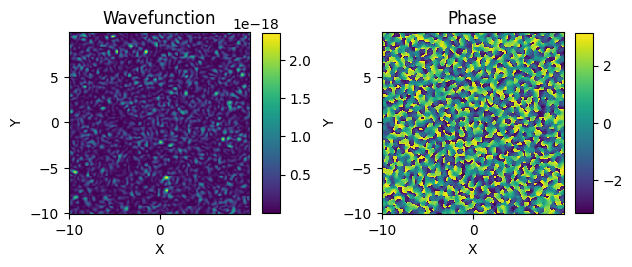

In [96]:
# Plot Results
data = np.loadtxt( os.path.join(result_path, "wavefunction_plus.txt") )
re,im = data[:grid_size,:], data[grid_size:,:]
psi = (re + 1j*im).reshape(grid_size,grid_size)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.set_title("Wavefunction")
plt_psi = ax1.pcolormesh(X,Y,np.abs(psi)**2)
ax2.set_title("Phase")
plt_phase = ax2.pcolormesh(X,Y,np.angle(psi))

for ax,plot in zip((ax1,ax2),(plt_psi,plt_phase)):
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect("equal")
    fig.colorbar(plot, ax=ax, shrink=0.4, aspect=10)

plt.tight_layout()

# Fourier Transform

Now we want to calculate the Fourier Transform of a specific time slice of the matrix. While PULSE can output a single X-Slice History Matrix, we can also simply output a history of complete matrices (at a lower resolution) for advanced data processing.

While we're on it, we may as well reconstruct the wavefunctions into a video!

We create functions to prepare and evaluate the data required for the Fourier Transform to reuse them in a parameter scan later.

In [99]:
# Execute PULSE with a specific pump amplitude
def generatePULSEData(pump_amp) -> None:
    """
    Generate the pump, save the pump, and generate the runstring
    Then, remove the previous timeoutput folder if it exists,
    and execute PULSE.
    """
    print(f"Running PULSE with pump amplitude {pump_amp}")
    pump = generate_pump(pump_amp)
    save_matrix(pump, "pump_plus.txt")
    runstring = generate_runstring( t_max = 1500.0, history=True )

    # Clear contents of the results folder
    timeoutput_folder = os.path.join(result_path, "timeoutput")
    if os.path.exists(timeoutput_folder):
        import shutil
        shutil.rmtree( timeoutput_folder )

    # Call the runstring and wait for the subprocess to finish
    from subprocess import Popen, PIPE
    process = Popen( runstring.split(), stdout=PIPE, stderr=PIPE, cwd = PULSE_CWD )
    stdout, stderr = process.communicate()

In [116]:
def readPULSEData() -> tuple:
    """
    After PULSE has finished, read in the timeoutput files,
    reconstruct the wavefunctions, and calculate the Fourier
    Transform of the wavefunctions.
    Return the wavefunctions, times, wavefunction cuts, Fourier
    Transform, and the subgrid size.
    """
    # Read in all matrix files in the results/timeoutput folder
    files = os.listdir( os.path.join(result_path, "timeoutput") )
    # Sort the files by ascending time
    files.sort(key=lambda x: float(x.split("_")[-1].replace(".txt", "")))
    # Take only the last 1000 iterations of the simulation
    files = files[-1000:]

    print(f"Reading {len(files)} timeoutput files")

    # Read in all the timeoutput files. .shape[1] is the subgrid size
    timeoutput = [ np.loadtxt( os.path.join(result_path, "timeoutput", file) ) for file in files ]
    subgrid_size = int(timeoutput[0].shape[1])
    print(f"Subgrid size: {subgrid_size}")

    # Reconstruct the wavefunctions
    wavefunctions = [data[:subgrid_size,:] + 1j*data[subgrid_size:,:] for data in timeoutput]
    times = [ float(file.split("_")[-1].replace(".txt", "")) for file in files ]

    real_dt = times[1] - times[0]
    real_dx = 2*x_max / grid_size
    samples = len(times)

    # Extract a cut of the wavefunction at a specific Y coordinate
    y_index = int(subgrid_size/2)
    wavefunction_cuts = np.array([ wavefunction[y_index,:] for wavefunction in wavefunctions ])
    
    # Interpolate the wavefunction cuts to increase the time resolution
    res_increase = 5
    from scipy.interpolate import interp1d
    interp = interp1d(times, wavefunction_cuts, axis=0)
    wavefunction_cuts = interp(np.linspace(times[0], times[-1], samples*res_increase) )

    # Calculate the Fourier Transform Frequencies
    W = 2*np.pi*np.linspace(-0.5, 0.5, samples*res_increase) / real_dt * res_increase

    # Calculate the Fourier Transform of the wavefunctions
    fft = np.array([ np.abs(np.fft.fftshift(np.fft.fft(wavefunction_cut))) for wavefunction_cut in wavefunction_cuts.T ])

    return wavefunctions,times,wavefunction_cuts,fft,W,subgrid_size,real_dx,real_dt

### Example

We will now perform an example calculation to test our functions. We will then also recreate the simulation using matplotlibs animation functions.

In [101]:
# As a test, we prepare the data for a fixed pump amplitude
pump_amp = 9
generatePULSEData(pump_amp)

Running PULSE with pump amplitude 9


In [117]:
# Read in the data
wavefunctions,times,wavefunction_cuts,fft,W,subgrid_size,real_dx,real_dt = readPULSEData()

Reading 1000 timeoutput files
Subgrid size: 100


### Animation

As we have already saved all of the matrices to the disk and loaded them into this notebook, we might as well reconstruct them into a video.

We create a X-Y-subgrid, plot the initial wavefunction and then animate the remaining matrices.

We save the animation into a .mp4 file.

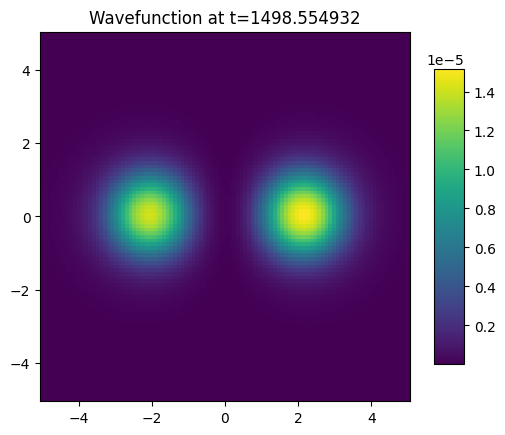

In [107]:
# Create an animation
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
ax.set_title("Wavefunction")
ax.set_xlabel("X")
ax.set_ylabel("Y")
sub_X = np.linspace(-subgrid_size/2, subgrid_size/2, subgrid_size)*real_dx
sub_Y = np.linspace(-subgrid_size/2, subgrid_size/2, subgrid_size)*real_dx

plt_psi = ax.pcolormesh(sub_X,sub_Y,np.abs(wavefunctions[0])**2)
cbar = fig.colorbar(plt_psi, ax=ax, shrink=0.8, aspect=10)
ax.set_aspect("equal")

def animate(i):
    ax.clear()
    plt_psi = ax.pcolormesh(sub_X,sub_Y,np.abs(wavefunctions[i])**2)
    ax.set_title(f"Wavefunction at t={times[i]}")

    # Set Colorbar data the the new plot
    plt_psi.colorbar = cbar
    plt_psi.colorbar.mappable = plt_psi
    plt_psi.colorbar.update_normal(plt_psi)

    print(f"Animating frame {i}/{len(times)}",end="\r")
    return plt_psi

anim = FuncAnimation(fig, animate, frames=len(wavefunctions), interval=100, repeat=True)
anim.save( os.path.join(result_path, f"wavefunction_{pump_amp}.mp4") )

### Wavefunction Cut Animation

We can also animate the cut that we have just extracted from the matrices.

We perform a similar animation as before, using a simple line plot instead of a pcolormesh.

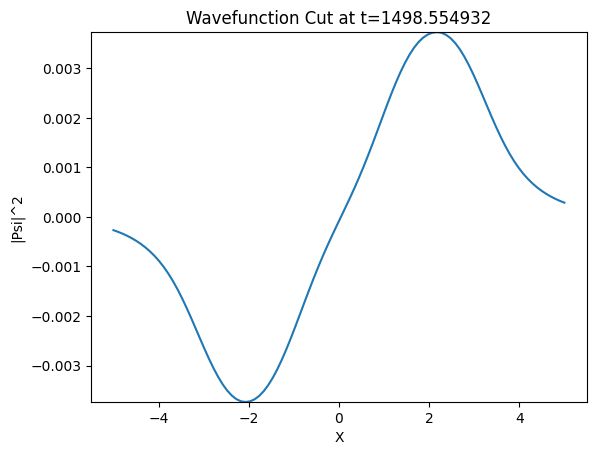

In [108]:
# Animate the wavefunction cuts
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
ax.set_title("Wavefunction Cut")
ax.set_xlabel("X")
ax.set_ylabel("|Psi|^2")

sub_X = np.linspace(-subgrid_size/2, subgrid_size/2, subgrid_size)*real_dx

plt_psi = ax.plot(sub_X,wavefunction_cuts[0].real)

y_lim = wavefunction_cuts.real.max()
ax.set_ylim(-y_lim, y_lim)

def animate(i):
    # Set data
    plt_psi[0].set_ydata(wavefunction_cuts[i].real)
    ax.set_title(f"Wavefunction Cut at t={times[i]}")

    print(f"Animating frame {i}/{len(times)}",end="\r")
    return plt_psi

anim = FuncAnimation(fig, animate, frames=len(wavefunctions), interval=100, repeat=True)
anim.save( os.path.join(result_path, f"wavefunction_cut_{pump_amp}.mp4") )



## Fourier Transform Plot

Now that we have generated and loaded the data from PULSE and calculated the Fourier Transform of each time slice, we can plot the FFT.

Energy: [1.25994239] -> [0.82930915] meV


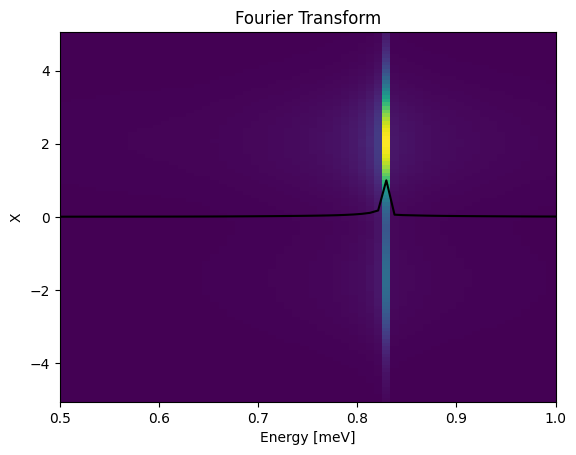

In [119]:
# Get the Maximum and Plot the Fourier Transform 
# Plot the Fourier Transform
fig, ax = plt.subplots()
ax.set_title("Fourier Transform")
ax.set_ylabel("X")
ax.set_xlabel("Energy [meV]")
ax.set_xlim(0.5,1)
ax.pcolormesh(W*hbar*1E3,np.linspace(-subgrid_size/2,subgrid_size/2,subgrid_size)*real_dx,fft)

# Integrate the FFT on the y-axis
fft_integrated = np.sum(fft, axis=0)
# Normalize the FFT
fft_integrated /= np.max(fft_integrated)
ax.plot(W*hbar*1E3, fft_integrated, color="black")
peaks, _ = find_peaks(fft_integrated, height=0.1)
energy = W[peaks]*hbar*1E3
print(f"Energy: {W[peaks]} -> {energy} meV")

## Parameter Scan

Now that we have prepared the execution of PULSE, defined a function to read-in the generated data and prepared the Fourier Transformation, we can finally generate a parameter scan of the first pump amplitude.

We overwrite the results every iteration to save on disk space. We could also update the result path accordingly to keep the data.

In [136]:
# Run Scan of the pump amplitude
pump_amp_scan = np.linspace(0, 15, 31, endpoint=True)

fft_cost_scan = []
fft_energy_lower, fft_energy_upper = [],[]

for pump_amp in pump_amp_scan:
    generatePULSEData(pump_amp)
    wavefunctions,times,wavefunction_cuts,fft,W,subgrid_size,real_dx,real_dt = readPULSEData()
    # Integrate the FFT on the y-axis
    fft_integrated = np.sum(fft, axis=0)
    # Normalize the FFT
    fft_integrated /= np.max(fft_integrated)
    # Analyze the peaks
    peaks, _ = find_peaks(fft_integrated, height=0.1)
    energy = W[peaks]*hbar*1E3
    print(f"Energy: {W[peaks]} Hz -> {energy} meV")
    if len(energy) > 1:
        fft_energy_lower.append( energy[0] )
    else:
        fft_energy_lower.append( np.nan )
    fft_energy_upper.append( energy[-1] )

    # Similar to before, we also calculate a cost value. In this case, since we already loaded all of the wavefunctions,
    # we will do an integrated cost instead of a final-value cost.
    cost = np.sum( [ np.sum(np.abs(wavefunction)**2) for wavefunction in wavefunctions ] )
    fft_cost_scan.append( cost )

# Save the results to disk
np.savetxt( os.path.join(result_path, "fft_cost_scan.txt"), np.array([pump_amp_scan, fft_cost_scan, fft_energy_lower, fft_energy_upper]).T )

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.65503153 0.64679214
 0.63855275 0.63855275 0.63031336 0.63031336 0.62207397 0.61383458
 0.61383458]
[0.79510116 0.78686177 0.78686177 0.77862238 0.77862238 0.77038299
 0.77038299 0.7621436  0.75390421 0.75390421 0.82805873 0.82805873
 0.83629812 0.83629812 0.83629812 0.82805873 0.82805873 0.82805873
 0.82805873 0.82805873 0.82805873 0.82805873 0.81981934 0.81981934
 0.81981934 0.81981934 0.81981934 0.81981934 0.81981934 0.81157995
 0.81157995]


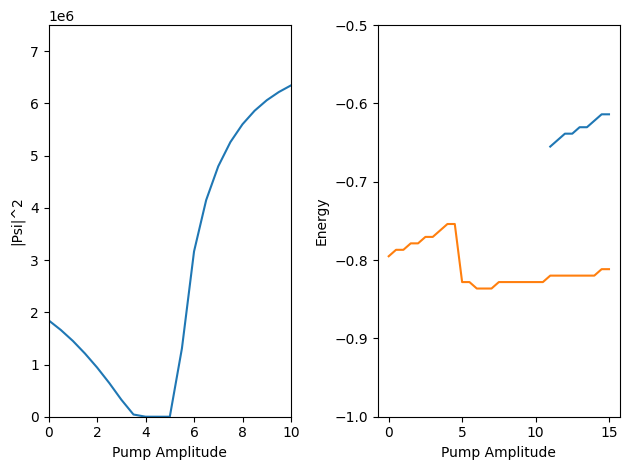

In [11]:
# Load the .txt
pump_amp_scan, fft_cost_scan, fft_energy_low, fft_energy_high = np.loadtxt( os.path.join(result_path, "fft_cost_scan.txt"), unpack=True )

# Plot the results
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(pump_amp_scan, fft_cost_scan)
ax1.set_xlabel("Pump Amplitude")
ax1.set_ylabel("|Psi|^2")
print(fft_energy_low)
print(fft_energy_high)
ax2.plot(pump_amp_scan, -fft_energy_low)
ax2.plot(pump_amp_scan, -fft_energy_high)
ax2.set_xlabel("Pump Amplitude")
ax2.set_ylabel("Energy")
ax1.set_ylim(0,0.75E7)
ax1.set_xlim(0,10)
ax2.set_ylim(-1,-0.5)
plt.tight_layout()

## Optimization

Alternatively, we can also use a simple GGA optimizer to find the exceptional point.

In [27]:
from scipy.optimize import minimize

def cost_function(parameters):
    """
    Cost function for the optimization
    |Psi|^2 has to be minimized
    """
    pump_amp = parameters[0]
    print(f"Running PULSE with pump amplitude {pump_amp}")
    # Generate the pump
    pump = generate_pump(pump_amp)
    # Save the pump
    save_matrix(pump, "pump_plus.txt")
    # Run PULSE
    runstring = generate_runstring(t_max = t_end)
    process = Popen( runstring.split(), stdout=PIPE, stderr=PIPE, cwd = PULSE_CWD )
    stdout, stderr = process.communicate()
    # Load the wavefunction
    re,im = np.loadtxt( os.path.join(result_path, "wavefunction_plus.txt"), usecols=(2,3), unpack=True )
    psi = (re + 1j*im).reshape(grid_size,grid_size)
    # Calculate the cost
    abs2_psi = np.abs(psi)**2
    cost_sum = np.sum( abs2_psi )
    cost_max = np.max( abs2_psi )
    print(f" -> Cost Sum: {cost_sum}, Max: {cost_max}")
    return cost_sum, cost_max

In [ ]:
# Run the Scipy Optimization
res = minimize(lambda param: cost_function(param)[0], x0=[6], method="Nelder-Mead", options={"maxiter": 100, "disp": True})